In [1]:
%pip install mplsoccer

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/CDAF/Projeto\ Final

/content/drive/MyDrive/Colab Notebooks/CDAF/Projeto Final


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import fmean
import math
from tqdm import tqdm
import time
import pickle

from mplsoccer import Pitch, VerticalPitch

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler


In [2]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [3]:
tqdm.pandas()

# Carregando dados

In [4]:
frames_general = pd.read_csv('frames_general.csv')
frames_coords = pd.read_csv('frames_coords.csv')
spadl = pd.read_csv('spadl.csv')

In [5]:
spadl[spadl['type_id'] == 1]

match_id    event_id  period_id  time_seconds  team_id  \
0        2128286  2253487625          1             0       90   
1        2128286  2253487639          1             2       90   
2        2128286  2253487685          1             7       90   
5        2128286  2253488059          1            47        1   
8        2128286  2253488079          1            50       90   
...          ...         ...        ...           ...      ...   
521422   2128605  2287659557          2          5597       49   
521423   2128605  2287659583          2          5600       49   
521424   2128605  2287659613          2          5603       49   
521430   2128605  2287660075          2          5672       49   
521431   2128605  2287660095          2          5676       49   

                team_name  player_id      player_name  type_id type_name  \
0                 Burnley      60551  Ashley Westwood        1      pass   
1                 Burnley      17761  James Tarkowski        1      pass   
2                 Burnley      68983   Matthew Lowton        1      pass   
5       Manchester United     141746  Bruno Fernandes        1      pass   
8                 Burnley     172782   Josh Brownhill        1      pass   
...                   ...        ...              ...      ...       ...   
521422   Sheffield United     109638       Kean Bryan        1      pass   
521423   Sheffield United      63426     Enda Stevens        1      pass   
521424   Sheffield United      79934   Oliver Norwood        1      pass   
521430   Sheffield United     108416        John Egan        1      pass   
521431   Sheffield United      63426     Enda Stevens        1      pass   

        start_x  start_y   end_x   end_y  result_id result_name  bodypart_id  \
0        52.815   34.204  32.025  34.204          1     success            1   
1        31.080   36.312  38.220  15.844          1     success            1   
2        43.365   12.512  90.300  49.708          1     success            1   
5        44.310   21.012  39.480  19.448          0        fail            1   
8        45.465   13.464  63.000  53.516          0        fail            1   
...         ...      ...     ...     ...        ...         ...          ...   
521422   56.280   66.028  48.930  63.580          1     success            1   
521423   47.880   57.868  44.940  46.308          1     success            1   
521424   45.675   45.492  75.705  61.948          0        fail            1   
521430   37.485   35.428  78.960  66.028          1     success            1   
521431   71.925   65.892  81.480  68.000          0        fail            1   

       bodypart_name  
0               foot  
1               foot  
2               foot  
5               foot  
8               foot  
...              ...  
521422          foot  
521423          foot  
521424          foot  
521430          foot  
521431          foot  

[348795 rows x 18 columns]

In [6]:
exemplo = frames_coords[frames_coords['event_id'] == 2302265379]
exemplo

match_id    event_id  frame  team team_status        x  x_opta  \
9748512   2128656  2302265379  45750     3     offense -12.8741   37.74   
9748513   2128656  2302265379  45750    36     defense  12.6185   62.02   
9748514   2128656  2302265379  45750     3     offense -15.2737   35.45   
9748515   2128656  2302265379  45750     3     offense   7.0877   56.75   
9748516   2128656  2302265379  45750     3     offense   9.0412   58.61   
9748517   2128656  2302265379  45750     3     offense  -5.8410   44.44   
9748518   2128656  2302265379  45750     3     offense  -7.8136   42.56   
9748519   2128656  2302265379  45750    36     defense   0.0283   50.03   
9748520   2128656  2302265379  45750    36     defense  -3.9190   46.27   
9748521   2128656  2302265379  45750    36     defense   1.2671   51.21   
9748522   2128656  2302265379  45750     3     offense  -1.8459   48.24   
9748523   2128656  2302265379  45750    36     defense   3.3722   53.21   
9748524   2128656  2302265379  45750     3     offense  -6.8408   43.48   
9748525   2128656  2302265379  45750    36     defense   5.7474   55.47   

         y_opta        y      vx      vy  accel_norm  speed_norm  player_id  \
9748512   66.37  11.1335 -0.0000 -0.0000      0.0000      0.0000     226597   
9748513   13.17 -25.0462 -0.0000 -0.0000      0.0000      0.0000     110735   
9748514   37.31  -8.6286  0.2524  0.0241     -0.3825      0.2535     156074   
9748515   61.47   7.8018  0.6960  1.1787      0.0000      1.3688     223340   
9748516    6.35 -29.6848  3.8340  0.8837      1.0380      3.9346     195735   
9748517    9.39 -27.6173 -0.0245  0.5594     -0.4921      0.5600     101184   
9748518   56.31   4.2921 -0.7836  2.3298     -0.5316      2.4581     167199   
9748519   31.38 -12.6586 -1.4918  0.8853      0.2052      1.7347     227127   
9748520   48.71  -0.8762 -0.2228  0.6659     -0.1944      0.7022     233425   
9748521   15.65 -23.3599  0.7377  0.8336     -0.3713      1.1132     235382   
9748522   33.89 -10.9574 -0.2951  0.4681      0.6117      0.5534     184029   
9748523   60.86   7.3846  0.5644  0.7525      0.2303      0.9407     243505   
9748524   30.50 -13.2583  0.3383  2.1588      1.1791      2.1851      84450   
9748525   46.58  -2.3276 -0.4417  0.8109     -0.3977      0.9234      39155   

        player_position  player_with_event  
9748512             LCB              False  
9748513             RCB              False  
9748514             RCB              False  
9748515              LW              False  
9748516              RW              False  
9748517             RWB              False  
9748518              RM              False  
9748519              DM              False  
9748520              CF              False  
9748521              LW              False  
9748522              AM              False  
9748523              LM              False  
9748524              LM               True  
9748525              LM              False

In [7]:
spadl['type_name'].value_counts()

pass                348795
bad_touch            25040
aerial_duel          24856
tackle               19019
throw_in             14879
clearance            14554
interception         13524
take_on              13444
cross                 9524
shot                  8710
freekick_short        7906
goalkick              5256
keeper_pick_up        4917
keeper_save           4781
corner_crossed        3164
freekick_crossed      1072
corner_short           686
keeper_claim           513
shot_freekick          359
keeper_punch           308
shot_penalty           125
Name: type_name, dtype: int64

In [8]:
passes_spadl = spadl[spadl['type_name'] == 'pass']

In [9]:
frames_coords['x'] = frames_coords['x']+52.5
frames_coords['y'] = frames_coords['y']+34
frames_coords['x_opta'] = frames_coords['x_opta']*(105/100)
frames_coords['y_opta'] = frames_coords['y_opta']*(68/100)

In [10]:
np.argmax(frames_coords['y'])

5254786

In [11]:
frames_coords.iloc[5254786]

match_id                2128482
event_id             2258205859
frame                     51790
team                         31
team_status             offense
x                       40.9526
x_opta                  40.4985
y_opta                   71.468
y                       71.4651
vx                      -0.4631
vy                      -0.8413
accel_norm               1.3971
speed_norm               0.9604
player_id                244723
player_position             LWB
player_with_event          True
Name: 5254786, dtype: object

In [12]:
spadl[spadl['event_id'] == 2258205859]

match_id    event_id  period_id  time_seconds  team_id  \
179906   2128482  2258205859          2          5159       31   

             team_name  player_id      player_name  type_id type_name  \
179906  Crystal Palace     244723  Tyrick Mitchell        3  throw_in   

        start_x  start_y   end_x  end_y  result_id result_name  bodypart_id  \
179906    35.07     68.0  23.625  55.76          1     success            1   

       bodypart_name  
179906          foot

# Visualizações

## Visualização 1

In [13]:
passes_spadl.sample(6)

match_id    event_id  period_id  time_seconds  team_id  \
140318   2128623  2293123419          2          2949       13   
518445   2128481  2258522381          2          4629       39   
417275   2128620  2293741777          2          5286       11   
485289   2128392  2241503171          1          1655       13   
8595     2128347  2227806713          1          1636        8   
88608    2128551  2273245733          1           777       43   

                      team_name  player_id      player_name  type_id  \
140318           Leicester City     166989  Youri Tielemans        1   
518445  Wolverhampton Wanderers     171317      Rúben Neves        1   
417275                  Everton     119765            Allan        1   
485289           Leicester City      86881   Nampalys Mendy        1   
8595                    Chelsea     219847      Kai Havertz        1   
88608           Manchester City     171314       Rúben Dias        1   

       type_name  start_x  start_y   end_x   end_y  result_id result_name  \
140318      pass   67.935    5.032  73.395   2.992          1     success   
518445      pass   36.750   54.128  73.290  61.948          0        fail   
417275      pass   64.050   40.528  62.790  49.028          1     success   
485289      pass   71.925   52.768  68.880  46.716          1     success   
8595        pass   49.560   20.060  50.715  24.276          1     success   
88608       pass   34.965   35.904  35.280  19.380          1     success   

        bodypart_id bodypart_name  
140318            2          head  
518445            1          foot  
417275            1          foot  
485289            1          foot  
8595              1          foot  
88608             1          foot

In [14]:
event_id_teste = 2225543615
event_test = spadl[spadl['event_id'] == event_id_teste]
frame_event_teste = frames_coords[frames_coords['event_id'] == event_id_teste]

In [15]:
event_test

match_id    event_id  period_id  time_seconds  team_id  team_name  \
153719   2128341  2225543615          2          4824       14  Liverpool   

        player_id          player_name  type_id type_name  start_x  start_y  \
153719      41733  Georginio Wijnaldum        1      pass    56.91   42.908   

        end_x   end_y  result_id result_name  bodypart_id bodypart_name  
153719  51.24  40.324          1     success            1          foot

In [16]:
frame_event_teste

match_id    event_id  frame  team team_status        x   x_opta  \
1481214   2128341  2225543615  58180    49     defense  73.7425  74.5815   
1481215   2128341  2225543615  58180    14     offense  68.0638  68.6805   
1481216   2128341  2225543615  58180    14     offense  51.4871  51.4500   
1481217   2128341  2225543615  58180    14     offense  71.7633  72.5235   
1481218   2128341  2225543615  58180    49     defense  72.6783  73.4790   
1481219   2128341  2225543615  58180    14     offense  61.0286  61.3620   
1481220   2128341  2225543615  58180    49     defense  65.3399  65.8455   
1481221   2128341  2225543615  58180    49     defense  61.3974  61.7505   
1481222   2128341  2225543615  58180    14     offense  60.0457  60.3435   
1481223   2128341  2225543615  58180    14     offense  56.0100  56.1540   
1481224   2128341  2225543615  58180    49     defense  57.7783  57.9915   
1481225   2128341  2225543615  58180    49     defense  52.9647  52.9830   
1481226   2128341  2225543615  58180    49     defense  55.6988  55.8285   

          y_opta        y      vx      vy  accel_norm  speed_norm  player_id  \
1481214  45.3968  45.3999 -1.4848  0.6803      0.0000      1.6333      40386   
1481215  27.7440  27.7436  1.2175  1.3874      0.7519      1.8458      92217   
1481216  40.3988  40.3981 -0.8469  1.0199     -1.0943      1.3256      56979   
1481217  50.1024  50.1054 -0.0449 -0.6508      0.3948      0.6524     110979   
1481218  51.1020  51.1000 -0.6972  0.6174     -3.2554      0.9313      82691   
1481219  19.8696  19.8688  0.4064  0.5962      0.9710      0.7216     194634   
1481220  30.7496  30.7524 -0.0218 -0.0936      0.1713      0.0961     199598   
1481221  41.9152  41.9170 -0.2814 -0.0504     -0.2823      0.2859     207189   
1481222  65.7492  65.7493 -0.2913  0.8636      0.2022      0.9114     122798   
1481223  43.5676  43.5665  0.2497 -0.0428      0.3906      0.2533      41733   
1481224  47.2804  47.2771 -1.3296 -0.6799      0.9337      1.4933      27436   
1481225  24.9832  24.9853 -1.0131  0.5541     -0.5784      1.1547     169432   
1481226  38.7056  38.7079 -2.1695  2.0515     -1.7840      2.9859     197937   

        player_position  player_with_event  
1481214             RCB              False  
1481215              AM              False  
1481216              RM              False  
1481217              LW              False  
1481218             RWB              False  
1481219              RW              False  
1481220              DM              False  
1481221              RM              False  
1481222             LWB              False  
1481223              LM               True  
1481224              LM              False  
1481225              RF              False  
1481226              CF              False

56.91


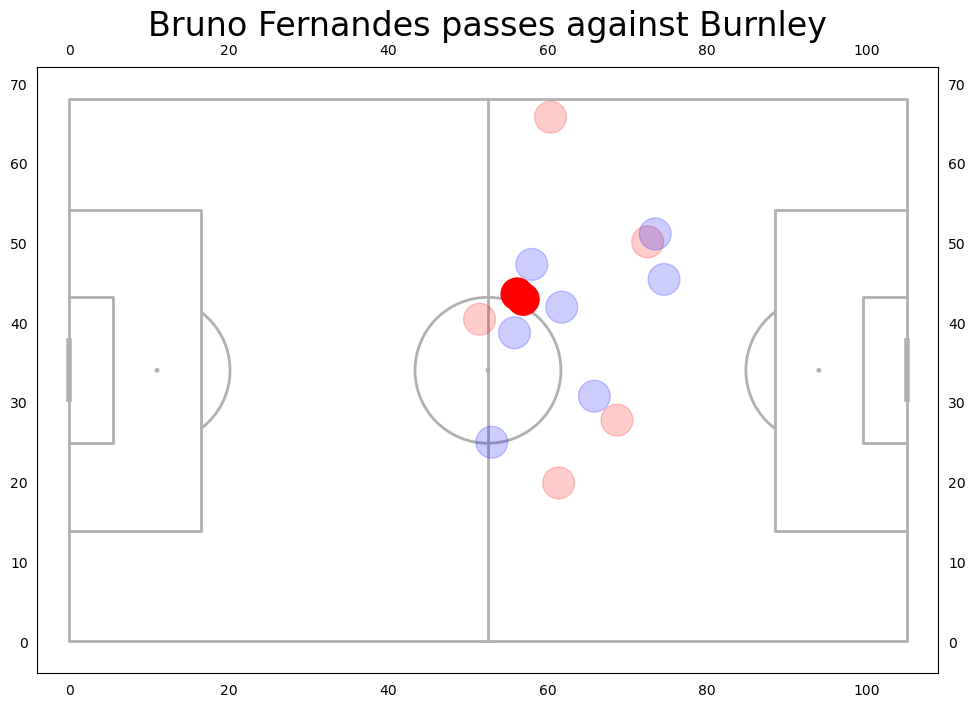

In [17]:
pitch = Pitch(pitch_type='uefa', pitch_length=105, pitch_width=68,  # example plotting a tracab pitch
              axis=True, label=True)
fig, ax = pitch.draw(figsize=(10, 7))

x = event_test['start_x'].values[0]
print(x)
y = event_test['start_y'].values[0]
id_person = event_test['player_id'].values[0]
name_person = event_test['player_name'].values[0]

circle = plt.Circle((x,y),2,color="red")
circle.set_alpha(1)
ax.add_patch(circle)

for i,person in frame_event_teste.iterrows():
    #if pass made by Lucy Bronze
    if person['team_status'] == "offense":
        x=person['x_opta']
        y=person['y_opta']
        #plot circle
        circle = plt.Circle((x,y),2,color="red")
        if person['player_with_event'] == True:
            circle.set_alpha(1)
        else:
            circle.set_alpha(.2)
        ax.add_patch(circle)
    else:
        x=person['x_opta']
        y=person['y_opta']
        #plot circle
        circle = plt.Circle((x,y),2,color="blue")
        if person['player_with_event'] == True:
            circle.set_alpha(1)
        else:
            circle.set_alpha(.2)
        ax.add_patch(circle)

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

## Visualização 2

In [18]:
passes_match_id = spadl[spadl['type_name'] == 'pass']
passes_match_id = passes_match_id[passes_match_id['match_id'] == 2128286]

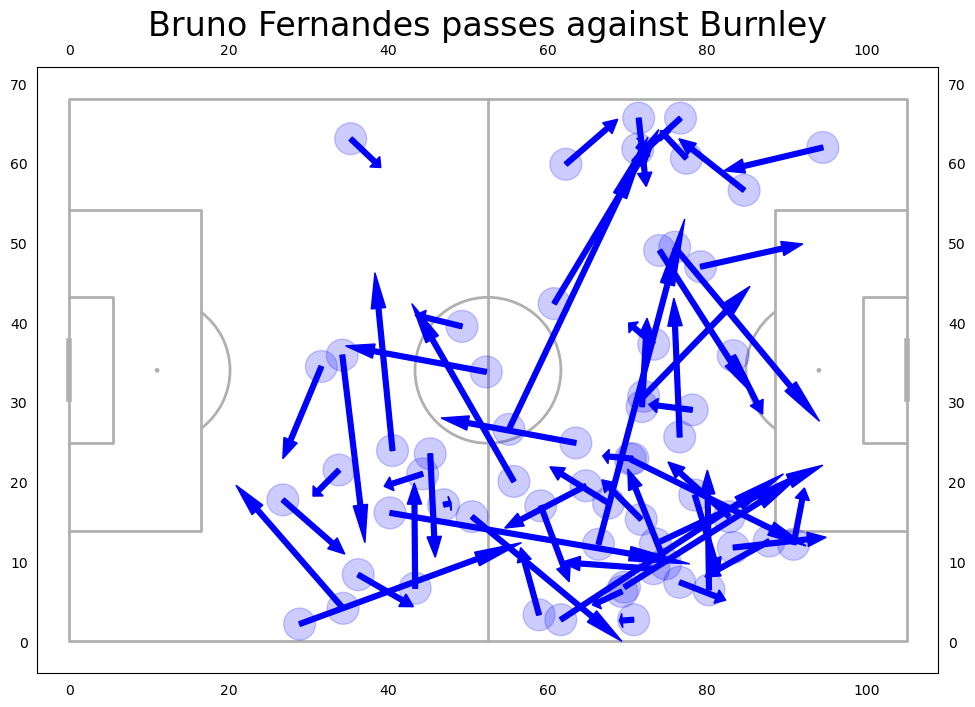

In [19]:
pitch = Pitch(pitch_type='uefa',  # example plotting a tracab pitch
              pitch_length=105, pitch_width=68,
              axis=True, label=True)
fig, ax = pitch.draw(figsize=(10, 7))

for i,thepass in passes_match_id.iterrows():
    #if pass made by Lucy Bronze
    if thepass['player_name']=='Bruno Fernandes':
        x=thepass['start_x']
        y=thepass['start_y']
        #plot circle
        passCircle=plt.Circle((x,y),2,color="blue")
        passCircle.set_alpha(.2)
        ax.add_patch(passCircle)
        dx=thepass['end_x']-x
        dy=thepass['end_y']-y
        #plot arrow
        passArrow=plt.Arrow(x,y,dx,dy,width=3,color="blue")
        ax.add_patch(passArrow)

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

## Visualização 3

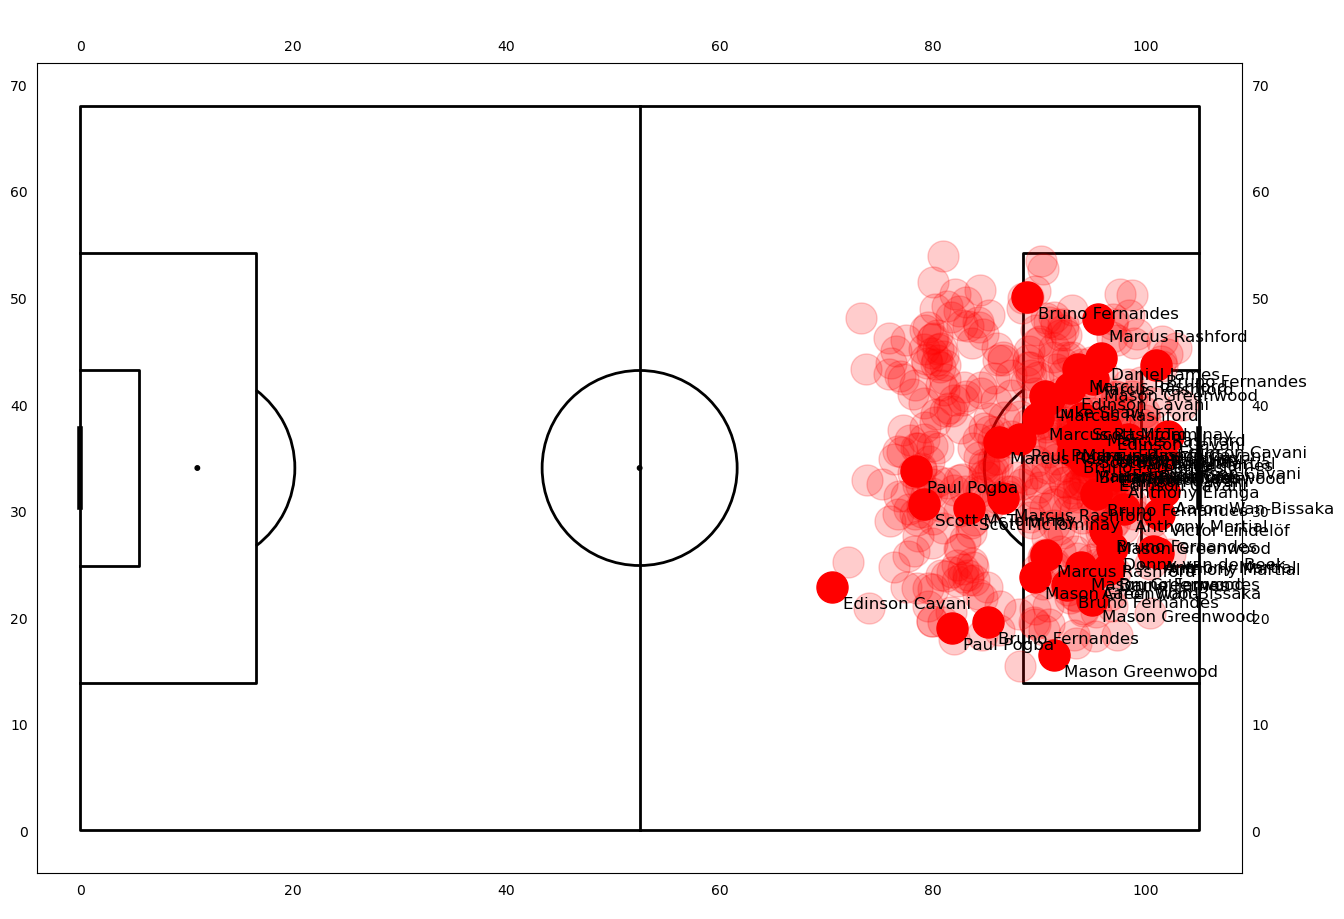

In [20]:
#create pitch
pitch = Pitch(line_color='black', pitch_type='uefa', pitch_length=105, pitch_width=68, axis=True, label=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#query
mask_england = (spadl.type_name == 'shot') & (spadl.team_name == 'Manchester United')
#finding rows in the df and keeping only necessary columns
df_england = spadl.loc[mask_england, ['start_x', 'start_y', 'result_name', "player_name"]]

#plot them - if shot ended with Goal - alpha 1 and add name
#for England
for i, row in df_england.iterrows():
    if row["result_name"] == 'success':
    #make circle
       pitch.scatter(row.start_x, row.start_y, alpha = 1, s = 500, color = "red", ax=ax['pitch'])
       pitch.annotate(row["player_name"], (row.start_x + 1, row.start_y - 2), ax=ax['pitch'], fontsize = 12)
    else:
       pitch.scatter(row.start_x, row.start_y, alpha = 0.2, s = 500, color = "red", ax=ax['pitch'])

# Pré-processamento

### Remover passes para jogadores fora do frame

In [21]:
receiver_in_frame_file = 'receiver_in_frame.pkl'
M = frames_coords[['event_id', 'player_id']].to_numpy()
dft = passes_spadl[passes_spadl['result_name'] == 'success']
dft['receiver_id'] = spadl.iloc[dft.index + 1]['player_id'].to_list()

if os.path.isfile(receiver_in_frame_file):
    with open(receiver_in_frame_file, 'rb') as f:
        receiver_in_frame = pickle.load(f)
    dft['receiver_in_frame'] = receiver_in_frame
else:
    #dft['receiver_in_frame'] = dft.progress_apply(lambda row: np.isin(row.receiver_id, M[np.where(M[:,0] == row.event_id)][:,1])*1, axis=1)
    dft['receiver_in_frame'] = dft.progress_apply(lambda row: row.receiver_id in M[np.where(M[:,0] == row.event_id)][:,1], axis=1)

    with open(receiver_in_frame_file, 'wb') as f:
        pickle.dump((dft['receiver_in_frame']*1).to_numpy(), f)

C:\Users\ferna\AppData\Local\Temp\ipykernel_41592\4121350588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['receiver_id'] = spadl.iloc[dft.index + 1]['player_id'].to_list()
C:\Users\ferna\AppData\Local\Temp\ipykernel_41592\4121350588.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['receiver_in_frame'] = receiver_in_frame


In [22]:
dft = dft[dft['receiver_in_frame']==1]

In [23]:
dff = passes_spadl[passes_spadl['result_name'] == 'fail']
passes_spadl_2 = pd.concat([dft, dff]).sort_index()

In [24]:
passes_spadl_2.drop(columns=['receiver_id', 'receiver_in_frame'], inplace=True)

## Event data

### Dicionário de jogadores, times e parte do corpo

In [25]:
passes_spadl_model = passes_spadl_2.copy(deep=True)

In [26]:
players_dict = dict()
teams_dict = dict()
bodypart_dict = dict()

In [27]:
def check_player(x):
    if x['player_id'] in players_dict.keys():
        pass
    else:
        players_dict[x['player_id']] = x['player_name']

def check_team(x):
    if x['team_id'] in teams_dict.keys():
        pass
    else:
        teams_dict[x['team_id']] = x['team_name']

def check_bodypart(x):
    if x['bodypart_id'] in teams_dict.keys():
        pass
    else:
        teams_dict[x['bodypart_id']] = x['bodypart_name']

In [28]:
spadl.apply(check_player, axis=1)
spadl.apply(check_team, axis=1)
spadl.apply(check_bodypart, axis=1);

### Calcular distância e ângulo do passe

In [29]:
def distancia2d(x1, y1, x2, y2):
    a = x2 - x1
    b = y2 - y1
    c = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
    return c

In [30]:
def angle_cos(xi,xf,d):
    cat_adj = xf-xi
    hip = d
    if hip == 0:
        hip=1
    cos = cat_adj/hip
    ang_in_radians = math.acos(cos)
    return ang_in_radians

In [31]:
passes_spadl_model['distance'] = [distancia2d(passe['start_x'], passe['start_y'], passe['end_x'], passe['end_y']) for i, passe in passes_spadl_model.iterrows()]

In [32]:
passes_spadl_model['angle'] = [angle_cos(passe['start_x'], passe['end_x'], passe['distance']) for i, passe in passes_spadl_model.iterrows()]

In [33]:
def distance_point_line_segment(point, segment_start, segment_end):
    if segment_end == segment_start:
      a = segment_end[0] - point[0]
      b = segment_end[1] - point[1]
      distance = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
      closest_point = segment_end
      return distance, closest_point
    point = np.array(point)
    segment_start = np.array(segment_start)
    segment_end = np.array(segment_end)

    # Calculate the direction vector of the line segment
    segment_direction = segment_end - segment_start

    # Calculate the vector from segment start to point
    point_vector = point - segment_start

    # Calculate the projection of point_vector onto the line segment
    projection = np.dot(point_vector, segment_direction) / np.dot(segment_direction, segment_direction)
    projection = np.clip(projection, 0, 1)  # Clip the projection to stay within the segment bounds

    # Calculate the closest point on the line segment
    closest_point = segment_start + projection * segment_direction

    # Calculate the distance between the point and the closest point
    distance = np.linalg.norm(point - closest_point)

    return distance

In [34]:
passes_spadl_model['distance_pass_to_goal'] = [distance_point_line_segment(point=(passe['start_x'], passe['start_y']), segment_start=(105, 30.34), segment_end=(105,37.66) ) for i, passe in passes_spadl_model.iterrows()]

In [35]:
def distance_to_sideline(point):
    d1 = distance_point_line_segment(point, segment_start=(0, 0), segment_end=(105,0))
    d2 = distance_point_line_segment(point, segment_start=(0, 68), segment_end=(105,68))
    d3 = distance_point_line_segment(point, segment_start=(105, 0), segment_end=(105,68))
    d4 = distance_point_line_segment(point, segment_start=(0, 0), segment_end=(0,68))
    return np.min([d1,d2,d3,d4])

In [36]:
passes_spadl_model['distance_pass_to_sideline'] = [distance_to_sideline(point=(passe['start_x'], passe['start_y'])) for i, passe in passes_spadl_model.iterrows()]

### Evento anterior

In [37]:
evento_anterior = []
#evento_2_anterior = []
#evento_3_anterior = []
#evento_4_anterior = []
#evento_5_anterior = []
for i, row in passes_spadl_model.iterrows():
    #if spadl.iloc[i-1]['type_name'] == 'pass' and spadl.iloc[i-1]['result_name'] == 'success':
    evento_anterior.append(spadl.iloc[i-1]['type_name'])
    #evento_2_anterior.append(spadl.iloc[i-2]['type_name'])
    #evento_3_anterior.append(spadl.iloc[i-3]['type_name'])
    #evento_4_anterior.append(spadl.iloc[i-4]['type_name'])
    #evento_5_anterior.append(spadl.iloc[i-5]['type_name'])

In [38]:
passes_spadl_model['previous_event_type'] = evento_anterior
#passes_spadl_model['2_previous_event_type'] = evento_2_anterior
#passes_spadl_model['3_previous_event_type'] = evento_3_anterior
#passes_spadl_model['4_previous_event_type'] = evento_4_anterior
#passes_spadl_model['5_previous_event_type'] = evento_5_anterior

## Tracking data

### Descobrir Receptor
Menor distância até a projeção do passe

In [39]:
df_passes = passes_spadl_model.copy()

In [40]:
df_passes = df_passes.query('start_x != end_x | start_y != end_y')

In [41]:
# Função para verificar a interseção da semirreta com o retângulo
def calcular_intersecao(ponto1, ponto2):
    retangulo = {
        'ponto1': (0,0),
        'ponto2': (105, 68)
    }
    # Coordenadas dos vértices do retângulo
    x1, y1 = retangulo['ponto1']
    x2, y2 = retangulo['ponto2']

    # Calcular a equação da reta
    dx = ponto2[0] - ponto1[0]
    dy = ponto2[1] - ponto1[1]

    # Verificar a inclinação da reta
    if dx != 0:
        m = dy / dx  # Inclinação da reta
    else:
        m = float('inf')  # Reta vertical (inclinação infinita)


    # Calcular a interseção com o lado esquerdo do retângulo
    x_intersecao = x1
    y_intersecao = ponto1[1] + m * (x_intersecao - ponto1[0])

    if y1 <= y_intersecao <= y2 and dx < 0:  # Verificar se o ponto de interseção está dentro do lado esquerdo do retângulo
        return x_intersecao, y_intersecao

    # Calcular a interseção com o lado direito do retângulo
    x_intersecao = x2
    y_intersecao = ponto1[1] + m * (x_intersecao - ponto1[0])

    if y1 <= y_intersecao <= y2 and dx > 0:  # Verificar se o ponto de interseção está dentro do lado direito do retângulo
        return x_intersecao, y_intersecao

    # Calcular a interseção com o lado superior do retângulo
    y_intersecao = y2
    if m != 0 and dy > 0:  # Evitar divisão por zero se a reta for horizontal
        x_intersecao = ponto1[0] + (y_intersecao - ponto1[1]) / m

        if x1 <= x_intersecao <= x2:  # Verificar se o ponto de interseção está dentro do lado superior do retângulo
            return x_intersecao, y_intersecao

    # Calcular a interseção com o lado inferior do retângulo
    y_intersecao = y1
    if m != 0 and dy < 0:  # Evitar divisão por zero se a reta for horizontal
        x_intersecao = ponto1[0] + (y_intersecao - ponto1[1]) / m

        if x1 <= x_intersecao <= x2:
          return x_intersecao, y_intersecao

   # Caso não haja interseção
    return None

In [42]:
df_passes['intersecao'] = df_passes.apply(lambda row: calcular_intersecao((row.start_x, row.start_y), (row.end_x, row.end_y)), axis=1)

In [43]:
df_passes['intersec_x'] = df_passes['intersecao'].apply(lambda x: x[0])
df_passes['intersec_y'] = df_passes['intersecao'].apply(lambda x: x[1])

In [44]:
frames_t = frames_coords.merge(df_passes[['end_x', 'end_y', 'start_x', 'start_y', 'intersec_y','intersec_x', 'event_id']], how='inner', left_on='event_id', right_on='event_id')

In [45]:
frames_t = frames_t[frames_t['team_status'] == 'offense']

In [46]:
def distance_point_line_segment(point, segment_start, segment_end):
    if segment_end == segment_start:
      a = segment_end[0] - point[0]
      b = segment_end[1] - point[1]
      distance = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
      closest_point = segment_end
      return distance, closest_point
    point = np.array(point)
    segment_start = np.array(segment_start)
    segment_end = np.array(segment_end)

    # Calculate the direction vector of the line segment
    segment_direction = segment_end - segment_start

    # Calculate the vector from segment start to point
    point_vector = point - segment_start

    # Calculate the projection of point_vector onto the line segment
    projection = np.dot(point_vector, segment_direction) / np.dot(segment_direction, segment_direction)
    projection = np.clip(projection, 0, 1)  # Clip the projection to stay within the segment bounds

    # Calculate the closest point on the line segment
    closest_point = segment_start + projection * segment_direction

    # Calculate the distance between the point and the closest point
    distance = np.linalg.norm(point - closest_point)

    return distance, closest_point

In [47]:
frames_t['distance_point_line_segment'] = frames_t.apply(lambda row: distance_point_line_segment(
                                                       (row.x_opta, row.y_opta),
                                                       (row.end_x, row.end_y),
                                                       (row.intersec_x, row.intersec_y)), axis=1)

In [48]:
frames_t['dist_to_segment'] = frames_t['distance_point_line_segment'].apply(lambda x: x[0])
frames_t['closest_point_x'] = frames_t['distance_point_line_segment'].apply(lambda x: x[1][0])
frames_t['closest_point_y'] = frames_t['distance_point_line_segment'].apply(lambda x: x[1][1])

In [49]:
frames_t.head()

match_id    event_id  frame  team team_status        x   x_opta   y_opta  \
3   2128286  2253487625   1391    90     offense  53.8090  53.8125  51.5644   
4   2128286  2253487625   1391    90     offense  29.6026  29.5995  52.3940   
5   2128286  2253487625   1391    90     offense  27.7570  27.7620  35.2376   
6   2128286  2253487625   1391    90     offense  36.6182  36.6135  16.9592   
9   2128286  2253487625   1391    90     offense  46.8240  46.8195  60.8056   

         y      vx  ...   end_x   end_y  start_x  start_y intersec_y  \
3  51.5660  3.4401  ...  32.025  34.204   52.815   34.204     34.204   
4  52.3917  0.1564  ...  32.025  34.204   52.815   34.204     34.204   
5  35.2345  0.0869  ...  32.025  34.204   52.815   34.204     34.204   
6  16.9626  0.5768  ...  32.025  34.204   52.815   34.204     34.204   
9  60.8074  0.9119  ...  32.025  34.204   52.815   34.204     34.204   

   intersec_x                        distance_point_line_segment  \
3         0.0  (27.858188103500204, [32.025, 34.20399999999999])   
4         0.0  (18.190000000000005, [29.599500000000003, 34.2...   
5         0.0  (1.033600000000007, [27.762000000000004, 34.20...   
6         0.0  (17.844816034075546, [32.025, 34.20399999999999])   
9         0.0  (30.438829688573787, [32.025, 34.20399999999999])   

   dist_to_segment  closest_point_x  closest_point_y  
3        27.858188          32.0250           34.204  
4        18.190000          29.5995           34.204  
5         1.033600          27.7620           34.204  
6        17.844816          32.0250           34.204  
9        30.438830          32.0250           34.204  

[5 rows x 26 columns]

Pondera Distância

In [50]:
# frames_test = frames_t.copy()
# frames_test = frames_test.iloc[:1000]

In [51]:
# frames_t.query("event_id == 2253487625")
frames_with_event = frames_t[frames_t['player_with_event'] == True]
frames_with_event = frames_with_event[['event_id', 'x_opta', 'y_opta']].rename(columns={'x_opta':'x_pass', 'y_opta':'y_pass'})
frames_t = frames_t.merge(frames_with_event[['event_id', 'x_pass', 'y_pass']], on='event_id')

In [52]:
frames_t = frames_t[frames_t['player_with_event'] == False]

In [53]:
def angle(r,g,b):
    r = np.array(r)
    g = np.array(g)
    b = np.array(b)
    gr = r - g
    gb = b - g

    cosine_angle = np.dot(gr, gb) / (np.linalg.norm(gr) * np.linalg.norm(gb))
    angle = np.arccos(cosine_angle)

    return (np.degrees(angle))

weight_distance =  lambda x: 1/(1+np.exp(-1*((x-60)/10))) + 1

In [54]:
frames_t['angle_pass'] = frames_t.apply(lambda row: angle((row.closest_point_x, row.closest_point_y),
                                    (row.x_pass, row.y_pass),(row.x_opta, row.y_opta)), axis=1)

C:\Users\ferna\AppData\Local\Temp\ipykernel_41592\2575701320.py:9: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


In [55]:
frames_t['angle_weight'] = frames_t['angle_pass'].apply(weight_distance)

In [56]:
frames_t['weighted_distance'] = frames_t['dist_to_segment']*frames_t['angle_weight']

Fim do pondera distância

In [57]:
closest_teammate = frames_t.groupby('event_id')['weighted_distance'].idxmin()
result = frames_t.loc[closest_teammate]

In [58]:
df_passes = df_passes.reset_index().merge(result[['event_id', 'closest_point_x', 'closest_point_y', 'x_opta', 'y_opta', 'player_id', 'angle_pass', 'angle_weight','weighted_distance']], how='left', left_on='event_id', right_on='event_id').set_index('index')

In [59]:
df_passes.rename(columns={"closest_point_x":"expected_end_x",
                        "closest_point_y":"expected_end_y",
                        "x_opta":"receiver_x",
                        "y_opta":"receiver_y",
                        "player_id_y":"intended_receiver_id"}, inplace=True)

In [60]:
frames_coords[frames_coords['event_id'] == 2253487625]

match_id    event_id  frame  team team_status        x   x_opta   y_opta  \
0    2128286  2253487625   1391     1     defense  73.0699  73.0695  48.8240   
1    2128286  2253487625   1391     1     defense  72.1386  72.1350  27.7780   
2    2128286  2253487625   1391     1     defense  73.4583  73.4580  40.8680   
3    2128286  2253487625   1391    90     offense  53.8090  53.8125  51.5644   
4    2128286  2253487625   1391    90     offense  29.6026  29.5995  52.3940   
5    2128286  2253487625   1391    90     offense  27.7570  27.7620  35.2376   
6    2128286  2253487625   1391    90     offense  36.6182  36.6135  16.9592   
7    2128286  2253487625   1391     1     defense  60.9480  60.9525  26.1732   
8    2128286  2253487625   1391     1     defense  51.7148  51.7125  25.8604   
9    2128286  2253487625   1391    90     offense  46.8240  46.8195  60.8056   
10   2128286  2253487625   1391    90     offense  44.5171  44.5200  39.8888   
11   2128286  2253487625   1391     1     defense  55.5004  55.5030  46.0700   
12   2128286  2253487625   1391     1     defense  56.8822  56.8785  54.7196   
13   2128286  2253487625   1391    90     offense  52.6606  52.6575  64.8720   
14   2128286  2253487625   1391     1     defense  66.2835  66.2865  41.4256   
15   2128286  2253487625   1391     1     defense  69.3751  69.3735  52.0812   
16   2128286  2253487625   1391    90     offense  51.6300  51.6285  24.6772   
17   2128286  2253487625   1391     1     defense  70.8475  70.8435  59.2416   
18   2128286  2253487625   1391    90     offense  52.6293  52.6260  33.2112   

          y      vx      vy  accel_norm  speed_norm  player_id  \
0   48.8252  0.1406 -0.2693      0.0000      0.3038     197365   
1   27.7808 -0.3755 -0.0670      0.2753      0.3815     106760   
2   40.8664  0.2215 -0.1173     -0.7083      0.2506      95658   
3   51.5660  3.4401 -1.7631     -3.8199      3.8656      60689   
4   52.3917  0.1564  0.7657     -1.1231      0.7815      51927   
5   35.2345  0.0869 -0.3566     -0.0952      0.3670      17761   
6   16.9626  0.5768 -1.2105     -0.8311      1.3409      68983   
7   26.1748  0.2740  1.0889     -2.7964      1.1229     148225   
8   25.8589 -3.2232  1.9560     -4.4803      3.7703      40720   
9   60.8074  0.9119  0.5154     -0.4851      1.0475      39487   
10  39.8898 -0.0438  1.0156     -0.9777      1.0166     172782   
11  46.0695 -0.8669  1.6270     -1.1781      1.8435     141746   
12  54.7223  0.1815  3.3702     -2.5373      3.3751     176297   
13  64.8737  3.3105  0.2988      0.0000      3.3240         -1   
14  41.4262  0.0944  1.0232     -1.6703      1.0275      62398   
15  52.0821  0.1901  0.9576     -0.7708      0.9763      74208   
16  24.6768 -1.6460  0.9843     -3.8271      1.9178      60586   
17  59.2407  0.8167  1.7434     -0.1091      1.9252     214590   
18  33.2125  0.8250 -1.3456     -0.6654      1.5784      60551   

   player_position  player_with_event  
0              RCB              False  
1              LWB              False  
2              LCB              False  
3               RF              False  
4              LCB              False  
5              RCB              False  
6              RWB              False  
7               LW              False  
8               CF              False  
9              LWB              False  
10              LM              False  
11              AM              False  
12              RW              False  
13             NaN              False  
14              LM              False  
15              RM              False  
16              RW              False  
17             RWB              False  
18              RM               True

In [61]:
df_passes

match_id    event_id  period_id  time_seconds  team_id  \
index                                                            
0        2128286  2253487625          1             0       90   
1        2128286  2253487639          1             2       90   
2        2128286  2253487685          1             7       90   
5        2128286  2253488059          1            47        1   
8        2128286  2253488079          1            50       90   
...          ...         ...        ...           ...      ...   
521416   2128605  2287659407          2          5579       39   
521417   2128605  2287659457          2          5580       39   
521422   2128605  2287659557          2          5597       49   
521424   2128605  2287659613          2          5603       49   
521431   2128605  2287660095          2          5676       49   

                      team_name  player_id_x      player_name  type_id  \
index                                                                    
0                       Burnley        60551  Ashley Westwood        1   
1                       Burnley        17761  James Tarkowski        1   
2                       Burnley        68983   Matthew Lowton        1   
5             Manchester United       141746  Bruno Fernandes        1   
8                       Burnley       172782   Josh Brownhill        1   
...                         ...          ...              ...      ...   
521416  Wolverhampton Wanderers       449988      Fábio Silva        1   
521417  Wolverhampton Wanderers       437858          Vitinha        1   
521422         Sheffield United       109638       Kean Bryan        1   
521424         Sheffield United        79934   Oliver Norwood        1   
521431         Sheffield United        63426     Enda Stevens        1   

       type_name  ...  intersec_x  intersec_y  expected_end_x  expected_end_y  \
index             ...                                                           
0           pass  ...    0.000000   34.204000       27.762000       34.204000   
1           pass  ...   43.746977    0.000000       38.996472       13.618114   
2           pass  ...  105.000000   61.357754       90.300000       49.708000   
5           pass  ...    0.000000    6.664000       38.233159       19.044261   
8           pass  ...   69.341180   68.000000       63.000000       53.516000   
...          ...  ...         ...         ...             ...             ...   
521416      pass  ...    6.751364    0.000000       33.295323       32.284361   
521417      pass  ...  102.040212    0.000000       69.825000       16.388000   
521422      pass  ...    0.000000   47.283314       45.761659       62.524749   
521424      pass  ...   86.749091   68.000000       75.705000       61.948000   
521431      pass  ...   81.480000   68.000000       81.480000       68.000000   

        receiver_x receiver_y  intended_receiver_id  angle_pass  angle_weight  \
index                                                                           
0          27.7620    35.2376               17761.0    2.372711      1.003133   
1          39.0810    13.6476               68983.0    0.218510      1.002527   
2          77.3325    41.4664               44699.0    3.889671      1.003644   
5          37.1490    22.3924               74208.0   20.876499      1.019602   
8          64.7955    49.0552               90517.0   18.935706      1.016200   
...            ...        ...                   ...         ...           ...   
521416     31.6470    33.6396              151589.0    9.464365      1.006346   
521417     42.3675    19.1692              159533.0   46.604369      1.207582   
521422     46.2210    61.1456               63426.0    6.646007      1.004795   
521424     72.0090    49.8304              197937.0   21.552860      1.020944   
521431     69.4680    67.1908               27436.0  179.348344      1.999993   

        weighted_distance  
index                      
0                1.036

In [62]:
df_passes = df_passes.dropna(subset = ['intended_receiver_id'])

In [63]:
df_passes = df_passes[df_passes['intended_receiver_id']>0]

In [64]:
df_passes['distance_passes_receiver'] = [distancia2d(passe['start_x'], passe['start_y'], passe['receiver_x'], passe['receiver_y']) for i, passe in df_passes.iterrows()]

In [65]:
frames_coords

match_id    event_id  frame  team team_status        x   x_opta  \
0         2128286  2253487625   1391     1     defense  73.0699  73.0695   
1         2128286  2253487625   1391     1     defense  72.1386  72.1350   
2         2128286  2253487625   1391     1     defense  73.4583  73.4580   
3         2128286  2253487625   1391    90     offense  53.8090  53.8125   
4         2128286  2253487625   1391    90     offense  29.6026  29.5995   
...           ...         ...    ...   ...         ...      ...      ...   
9966247   2128665  2302283951  62049    39     defense   7.9316   7.9275   
9966248   2128665  2302283951  62049    39     defense   7.7951   7.7910   
9966249   2128665  2302283951  62049     1     offense  10.8173  10.8150   
9966250   2128665  2302283951  62049     1     offense   5.7604   5.7645   
9966251   2128665  2302283951  62049     1     offense   6.2160   6.2160   

          y_opta        y      vx      vy  accel_norm  speed_norm  player_id  \
0        48.8240  48.8252  0.1406 -0.2693      0.0000      0.3038     197365   
1        27.7780  27.7808 -0.3755 -0.0670      0.2753      0.3815     106760   
2        40.8680  40.8664  0.2215 -0.1173     -0.7083      0.2506      95658   
3        51.5644  51.5660  3.4401 -1.7631     -3.8199      3.8656      60689   
4        52.3940  52.3917  0.1564  0.7657     -1.1231      0.7815      51927   
...          ...      ...     ...     ...         ...         ...        ...   
9966247  34.7412  34.7379 -1.1561 -1.3716      1.6599      1.7939      73314   
9966248  23.9632  23.9665 -0.8269  0.7946      0.5552      1.1469     449988   
9966249  34.3536  34.3533 -0.1988 -1.6911      2.2363      1.7028     152590   
9966250  19.2372  19.2369  1.3386 -1.4173      1.4875      1.9495     232937   
9966251  26.7988  26.7964 -0.4289  1.1253      0.7879      1.2043      62398   

        player_position  player_with_event  
0                   RCB              False  
1                   LWB              False  
2                   LCB              False  
3                    RF              False  
4                   LCB              False  
...                 ...                ...  
9966247              CF              False  
9966248              CF              False  
9966249             LWB              False  
9966250             RWB              False  
9966251              LM              False  

[9966252 rows x 16 columns]

### Tempo de Movimento

In [66]:
MAX_SPEED = 7          # 7 m/s == 25.6 km/h
ACCEL = 2.5            # 2.5m/s2 | Vi em um lugar lá que o Messi chegou a 3.2 de aceleração, então 2.5 pareceu uma média justa
REACTION_TIME = 0.15   # 150 ms
DEACCEL = 7  - ACCEL   # baseado em absolutamente nada

In [67]:
def time_to_arrive(distance, dest_direction, cur_direction, cur_speed):
    '''
    distance:       float          distance to be travelled
    dest_direction: (float, float) tuple with the direction the player most go, doesn't need to be normalized
    cur_direction:  (float, float) tuple with the direction the player is currently moving, doesn't need to be normalized
    cur_speed:      (float, float) tuple with the current speed of the player
    
    '''
    
    
    if cur_speed == 0:
        cur_direction = (0,0)
    else:
        cur_direction = cur_direction/np.linalg.norm(cur_direction)
        
    dest_direction = dest_direction/np.linalg.norm(dest_direction)


    # Estimating how much player must deaccelerate to change directions
    direction_change_angle = np.arccos(np.clip(np.dot(cur_direction, dest_direction), -1.0, 1.0))
    deaccel_amount = cur_speed * (direction_change_angle/np.pi)

    deaccel_time = deaccel_amount/ (DEACCEL + ACCEL)


    # Calculating player movement during deacceleration

    cur_speed = cur_speed - deaccel_amount

    mov = deaccel_time * (cur_speed) * dest_direction #How much the player moves in right direction during change of direction

    speed_delta = (dest_direction - cur_direction) * cur_speed

    change_dist = deaccel_time * (speed_delta / 2) * cur_direction

    

    mov_total = distance * dest_direction

    
    mov_total = mov_total + change_dist


    cur_speed = cur_speed - deaccel_amount

    




    # Calculating the time the layer needs for the rest of the path
    # Time is given by formula: t = (-v0 ± √(v0^2 + 2 * a * d)) / a

    delta_accel = MAX_SPEED - cur_speed
    accel_time = delta_accel / ACCEL

    accel_mov = accel_time * ((MAX_SPEED + cur_speed)/2)

    mov_total = mov_total - accel_mov

    d = np.abs(mov_total[0] + mov_total[1])


    t = (-cur_speed + (np.sqrt(cur_speed * cur_speed + 2*ACCEL*d)))/ACCEL

    if np.isnan(t):
        print(distance, dest_direction, cur_direction, cur_speed)
        aaaaaaaaaaaa


    return t + deaccel_time + REACTION_TIME

    
    





In [221]:
def calculate_tta(x, original_x, original_y, team_player):
    if x['team'] == team_player:
        return -1
    else: 
        distance = distancia2d(x['x_opta'], x['y_opta'], original_x, original_y)
        dest_direction = (original_x - x['x_opta'], original_y - x['y_opta'])
        cur_direction = (x['vx'], x['vy'])
        cur_speed = x['speed_norm']


        if np.isnan(cur_speed) or cur_speed == 0:
            cur_speed = 0
            cur_direction = (0,0)


        return time_to_arrive(distance, dest_direction, cur_direction, cur_speed)

In [181]:
time_to_arrive(10, (1,0), (1,1), 5)

2.3154672183917557

In [70]:
def get_influence(t):
    return np.tanh(t/1.5)

In [71]:
for i in range(1, 200, 10):
    print(get_influence(i/100))

0.0066665679029903665
0.07320215870718144
0.139092447878458
0.20377375936011308
0.2667237739579079
0.32747739480870536
0.38563872440840596
0.4408886478609151
0.49298796667532435
0.5417764250076493
0.5871682693574664
0.6291451614140355
0.6677473234566988
0.703063755578571
0.7352222529158692
0.7643798000958608
0.7907137568230043
0.814414093765686
0.8356768049310632
0.8546985178563733


In [246]:
INITIAL_BALL_SPEED = 12  # 10 m/s | A velocidade deve mudar baseada na distância do passe: Sf = Si + d/5
BALL_DEACCEL_GRASS = 8   # 8 m/s2 | parece verídico
BALL_DEACCEL_AIR = ((1.2 * 0.18 * 0.15) / 2) / 0.4  # (air density * ball coefficient * ball area) / 2) / ball mass) This needs to be multiplied by v^2 to get thhe deacceleration

#  10 * 2.5


def get_ball_travell_time(d):
    
    # Since we don't know wheter the ball is on the air or grass, we assume long passes will be on air
    # We use 20 meters as a threshhold, since at this distance, a pass travelling through the grass would come close to stopping at larger distances
    if d > 20:
        ball_speed = INITIAL_BALL_SPEED + d/6
        ball_deaccel = (BALL_DEACCEL_AIR * (ball_speed ** 2)) / 5 # we divide by 5 to approximate the deacceleration reduction with the ball's speed
    else:
        ball_speed = INITIAL_BALL_SPEED + d/3 + 1
        ball_deaccel = BALL_DEACCEL_GRASS

    ball_deaccel = -ball_deaccel



    t = (-ball_speed + (np.sqrt(np.abs(ball_speed * ball_speed + 2*ball_deaccel*d))))/ball_deaccel

    return t

In [73]:
print(BALL_DEACCEL_AIR)

0.040499999999999994


In [74]:
for t in range(20, 60, 2):
    print("======================")
    print(t, get_ball_travell_time(t))

20 1.4368624439890612
22 1.5583384964124252
24 1.6836974426876348
26 1.8080947538593397
28 1.9319352259033096
30 2.055643186947009
32 2.1796719165534264
34 2.3045154213512116
36 2.4307236237122156
38 2.5589225589225584
40 2.689842070319754
42 2.824355029213107
44 2.9635348641189627
46 3.1087433862840017
48 3.2617713277650378
50 3.425076537012341
52 3.602218250743225
54 3.798729451739667
56 4.024126595864836
58 4.297640372940796


### Pressão ao passador

In [75]:
numpy_frames_coords_event_id = frames_coords['event_id'].values

def check_distance_tracking(row, x_player, y_player, team_player):
    if row['team'] == team_player:
        return np.inf
    else:
        return distancia2d(x_player, y_player, row['x'], row['y'])

def check_close_players(row):

    pass_tracking = frames_coords[numpy_frames_coords_event_id == row['event_id']]

    player_with_event_tracking = pass_tracking[pass_tracking['player_with_event'].values == True]

    if len(player_with_event_tracking['x']) == 1:
        x_player = player_with_event_tracking['x'].values[0]
        y_player = player_with_event_tracking['y'].values[0]
        team_player = player_with_event_tracking['team'].values[0]


        distance = pass_tracking.apply(check_distance_tracking, args=(x_player, y_player, team_player), axis=1).values
        
        tta = pass_tracking.apply(calculate_tta, args=(x_player, y_player, team_player), axis=1).values

        pressure = 1
        for t in tta:
            if t == -1:
                continue
            else:
                pressure = pressure * get_influence(t)
        pressure = 1-pressure
        
        
        #meio_fim = time.time()

        close_distances = [i for i in distance if i<=7]

        num_perto = len(close_distances)   #Número de adversários perto do passador

        if num_perto>0:
            mean_distance_lower = fmean(close_distances)
            closest = np.min(close_distances)
            #fim = time.time()
            #print(fim-meio_fim,meio_fim-meio,meio-inicio_meio, inicio_meio-inicio)
            return (num_perto, mean_distance_lower, closest, pressure)
        else:
            return (0,0,0, pressure)
    else:
        return 0

In [76]:
#distance_all = df_passes.progress_apply(check_close_players, axis=1)

In [77]:
passer_file_name = 'passer.pkl'

if os.path.isfile(passer_file_name):
    with open(passer_file_name, 'rb') as f:
        passer_contested = pickle.load(f)
else:
    distance_all = df_passes.progress_apply(check_close_players, axis=1)
    passer_contested = distance_all.values

    with open(passer_file_name, 'wb') as f:
        pickle.dump(passer_contested, f)

In [78]:
n_close_players_passer = [i[0] if type(i)!=int else 0 for i in passer_contested]
close_players_mean_distance_passer = [1/i[1] if (type(i)!=int and i[1]!=0) else 0 for i in passer_contested]
closest_player_distance_passer = [1/i[2] if (type(i)!=int and i[2]!=0) else 0 for i in passer_contested]
pressure = [i[3] for i in passer_contested]

In [79]:
df_passes['n_close_players_passer'] = n_close_players_passer
df_passes['close_players_mean_distance_passer'] = close_players_mean_distance_passer
df_passes['closest_player_distance_passer'] = closest_player_distance_passer
df_passes['pressure_to_passer'] = pressure

In [80]:
df_passes['pressure_to_passer']

index
0         0.436642
1         0.360604
2         0.041287
5         0.953769
8         0.927425
            ...   
521416    0.856994
521417    0.767621
521422    0.690633
521424    0.244777
521431    0.789155
Name: pressure_to_passer, Length: 241398, dtype: float64

### Pressão ao receptor

In [81]:
def get_influence_receiver(t, d):
    ball_time = get_ball_travell_time(d)

    return np.tanh(t/ball_time)

In [82]:
numpy_frames_coords_event_id = frames_coords['event_id'].values

def check_distance_tracking(row, x_player, y_player, team_player):
    if row['team'] == team_player:
        return np.inf
    else:
        return distancia2d(x_player, y_player, row['x'], row['y'])

def check_close_players(row):

    receiver_id = row['intended_receiver_id']

    pass_tracking = frames_coords[numpy_frames_coords_event_id == row['event_id']]

    player_receiver_tracking = pass_tracking[pass_tracking['player_id'].values == receiver_id]
    player_with_event_tracking = pass_tracking[pass_tracking['player_with_event'].values == True]

    if len(player_receiver_tracking['x']) == 1:
        x_player = player_receiver_tracking['x'].values[0]
        y_player = player_receiver_tracking['y'].values[0]
        team_player = player_receiver_tracking['team'].values[0]

        distance = pass_tracking.apply(check_distance_tracking, args=(x_player, y_player, team_player), axis=1).values
        #meio_fim = time.time()

        close_distances = [i for i in distance if i<=5]

        num_perto = len(close_distances)   #Número de adversários perto do passador

        tta = pass_tracking.apply(calculate_tta, args=(x_player, y_player, team_player), axis=1).values

        pressure = 1
        passer_x = player_with_event_tracking['x'].values[0]
        passer_y = player_with_event_tracking['y'].values[0]
        d = np.sqrt((x_player - passer_x) ** 2 + (y_player - passer_y) ** 2)
        for t in tta:
            if t == -1:
                continue
            else:
                pressure = pressure * get_influence_receiver(t, d)
        pressure = 1-pressure

        if num_perto>0:
            mean_distance_lower = fmean(close_distances)
            closest = np.min(close_distances)
            #fim = time.time()
            #print(fim-meio_fim,meio_fim-meio,meio-inicio_meio, inicio_meio-inicio)
            return (num_perto, mean_distance_lower, closest, pressure)
        else:
            return (0,0,0, pressure)
    else:
        #print(player_receiver_tracking)
        print(receiver_id)
        return 0

In [83]:
#distance_all = df_passes.progress_apply(check_close_players, axis=1)

In [84]:
receiver_file_name = 'receiver.pkl'

if os.path.isfile(receiver_file_name):
    with open(receiver_file_name, 'rb') as f:
        receiver_contested = pickle.load(f)
else:
    distance_all = df_passes.progress_apply(check_close_players, axis=1)
    receiver_contested = distance_all.values

    with open(receiver_file_name, 'wb') as f:
        pickle.dump(receiver_contested, f)

In [85]:
n_close_players_receiver = [i[0] if type(i)!=int else 0 for i in receiver_contested]
close_players_mean_distance_receiver = [1/i[1] if (type(i)!=int and i[1]!=0) else 0 for i in receiver_contested]
closest_player_distance_receiver = [1/i[2] if (type(i)!=int and i[2]!=0) else 0 for i in receiver_contested]
pressure_receiver = [i[3] for i in receiver_contested]


In [86]:
df_passes['n_close_players_receiver'] = n_close_players_receiver
df_passes['close_players_mean_distance_receiver'] = close_players_mean_distance_receiver
df_passes['closest_player_distance_receiver'] = closest_player_distance_receiver
df_passes['pressure_to_receiver'] = pressure_receiver

In [87]:
df_passes['pressure_to_receiver']

index
0         0.124851
1         0.004642
2         0.958340
5         0.420003
8         0.456133
            ...   
521416    0.144740
521417    0.565603
521422    0.115610
521424    0.419054
521431    0.000443
Name: pressure_to_receiver, Length: 241398, dtype: float64

### Interceptação ao passe

In [88]:
def get_influence_pass(t, d):
    ball_time = get_ball_travell_time(d)

    return np.tanh(t/ball_time)

In [89]:
df_passes

match_id    event_id  period_id  time_seconds  team_id  \
index                                                            
0        2128286  2253487625          1             0       90   
1        2128286  2253487639          1             2       90   
2        2128286  2253487685          1             7       90   
5        2128286  2253488059          1            47        1   
8        2128286  2253488079          1            50       90   
...          ...         ...        ...           ...      ...   
521416   2128605  2287659407          2          5579       39   
521417   2128605  2287659457          2          5580       39   
521422   2128605  2287659557          2          5597       49   
521424   2128605  2287659613          2          5603       49   
521431   2128605  2287660095          2          5676       49   

                      team_name  player_id_x      player_name  type_id  \
index                                                                    
0                       Burnley        60551  Ashley Westwood        1   
1                       Burnley        17761  James Tarkowski        1   
2                       Burnley        68983   Matthew Lowton        1   
5             Manchester United       141746  Bruno Fernandes        1   
8                       Burnley       172782   Josh Brownhill        1   
...                         ...          ...              ...      ...   
521416  Wolverhampton Wanderers       449988      Fábio Silva        1   
521417  Wolverhampton Wanderers       437858          Vitinha        1   
521422         Sheffield United       109638       Kean Bryan        1   
521424         Sheffield United        79934   Oliver Norwood        1   
521431         Sheffield United        63426     Enda Stevens        1   

       type_name  ...  weighted_distance  distance_passes_receiver  \
index             ...                                                
0           pass  ...           1.036838                 25.074312   
1           pass  ...           0.089750                 24.035204   
2           pass  ...          15.420885                 44.633489   
5           pass  ...           3.588278                  7.292834   
8           pass  ...           4.886490                 40.501873   
...          ...  ...                ...                       ...   
521416      pass  ...           2.147469                  9.163518   
521417      pass  ...          33.326841                 16.589989   
521422      pass  ...           1.460602                 11.181293   
521424      pass  ...          12.934067                 26.688973   
521431      pass  ...          24.078372                  2.779160   

        n_close_players_passer  close_players_mean_distance_passer  \
index                                                                
0                            0                            0.000000   
1                            0                            0.000000   
2                            0                            0.000000   
5                            3                            0.191701   
8                            2                            0.708785   
...                        ...                                 ...   
521416                       1                            0.145441   
521417                       1                            0.240012   
521422                       1                            0.220767   
521424                       1                            0.150407   
521431                       2                            0.394317   

        closest_player_distance_passer pressure_to_passer  \
index                                                       
0                             0.000000           0.436642   
1                             0.000000           0.360604   
2                             0.000000           0.041287   
5                             0.252916           0.953769  

In [211]:
def distance_point_line_segment(row, segment_start_x, segment_start_y, segment_end_x, segment_end_y, team_player):
    if row['team'] == team_player:

       return np.inf

    point = [row['x'], row['y']]
    segment_start = [segment_start_x, segment_start_y]
    segment_end = [segment_end_x, segment_end_y]

    if segment_end == segment_start:
      a = segment_end[0] - point[0]
      b = segment_end[1] - point[1]
      distance = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
      closest_point = segment_end

      return distance
    point = np.array(point)
    segment_start = np.array(segment_start)
    segment_end = np.array(segment_end)

    # Calculate the direction vector of the line segment
    segment_direction = segment_end - segment_start

    # Calculate the vector from segment start to point
    point_vector = point - segment_start

    # Calculate the projection of point_vector onto the line segment
    projection = np.dot(point_vector, segment_direction) / np.dot(segment_direction, segment_direction)
    projection = np.clip(projection, 0, 1)  # Clip the projection to stay within the segment bounds

    # Calculate the closest point on the line segment
    closest_point = segment_start + projection * segment_direction

    

    # Calculate the distance between the point and the closest point
    distance = np.linalg.norm(point - closest_point)

    return distance

In [241]:

def calculate_time_to_ball(row, segment_start_x, segment_start_y, segment_end_x, segment_end_y, team_player):
    if row['team'] == team_player:
       return -1
    point = [row['x'], row['y']]
    segment_start = [segment_start_x, segment_start_y]
    segment_end = [segment_end_x, segment_end_y]

    if segment_end == segment_start:
      a = segment_end[0] - point[0]
      b = segment_end[1] - point[1]
      closest_point = segment_end
      return closest_point
    point = np.array(point)
    segment_start = np.array(segment_start)
    segment_end = np.array(segment_end)

    # Calculate the direction vector of the line segment
    segment_direction = segment_end - segment_start

    # Calculate the vector from segment start to point
    point_vector = point - segment_start

    # Calculate the projection of point_vector onto the line segment
    projection = np.dot(point_vector, segment_direction) / np.dot(segment_direction, segment_direction)
    projection = np.clip(projection, 0, 1)  # Clip the projection to stay within the segment bounds

    # Calculate the closest point on the line segment
    closest_point = segment_start + projection * segment_direction

    return calculate_tta(row, closest_point[0], closest_point[1], team_player)

In [251]:
numpy_frames_coords_event_id = frames_coords['event_id'].values

def check_close_players_pass_line(row):

    pass_tracking = frames_coords[numpy_frames_coords_event_id == row['event_id']]

    player_with_event_tracking = pass_tracking[pass_tracking['player_with_event'].values == True]

    if len(player_with_event_tracking['x']) == 1:
        x_player = player_with_event_tracking['x'].values[0]
        y_player = player_with_event_tracking['y'].values[0]
        team_player = player_with_event_tracking['team'].values[0]
    else:
        x_player = row['start_x']
        y_player = row['end_x']
        team_player = row['team_id']

    distance = pass_tracking.apply(distance_point_line_segment, args=(x_player, y_player, row['expected_end_x'], row['expected_end_y'], team_player), axis=1).values
    tta = pass_tracking.apply(calculate_time_to_ball, args=(x_player, y_player, row['expected_end_x'], row['expected_end_y'], team_player), axis=1).values
    meio_fim = time.time()
    close_distances = [i for i in distance if i<=7]

    num_perto = len(close_distances)   #Número de adversários perto do passador
    pressure = 1
    for i, t in enumerate(tta):
        if t == -1:

            continue
        else:

            pressure = pressure * get_influence_pass(t, distance[i])
    pressure = 1-pressure

    if num_perto>0:
        mean_distance_lower = fmean(close_distances)
        closest = np.min(close_distances)
        #fim = time.time()
        #print(fim-meio_fim,meio_fim-meio,meio-inicio_meio, inicio_meio-inicio)
        return (num_perto, mean_distance_lower, closest, pressure)
    else:
        return (0,0,0, pressure)

In [249]:
distance_all = df_passes.progress_apply(check_close_players_pass_line, axis=1)

  0%|          | 15/241398 [00:00<1:30:17, 44.56it/s]

0.15350162372055243
0.08811322931821375
0.9800820927669771
0.1967139851230113
0.339615606540728
0.026570549245096164
0.009759894233676403
0.012535536404323588
0.15292345930452655
0.05566603926059066
0.17443099086913316
0.005845558224689018
0.20340652607496534
0.041425993395516114


  0%|          | 23/241398 [00:00<1:12:32, 55.45it/s]

0.09455639861267229
0.005313586044361718
0.03743852578049156
0.0023223301002708308
0.021775867722819475
0.24916491721458123
0.004999729628453298
0.13636690628471537
0.34745738788953606
0.04015269029677637
0.9513609789918369
0.6256807858521081
0.009331099738863924
0.2830246323673097


  0%|          | 37/241398 [00:00<1:07:25, 59.66it/s]

0.02179280258785643
0.1415383921122092
0.0652397681157818
0.01428438929942355
0.2743608282882656
0.012871454743973887
0.01017375120587971
0.1922893428747351
0.1508359985074048
0.5569724203781861
0.0038183512716019052
0.0063865066179952246
0.1201249402486193
0.08796715120833365


  0%|          | 51/241398 [00:00<1:04:51, 62.02it/s]

0.019025973126551632
0.25685464589880924
0.01099353910487244
0.38726950887861444
0.2313402259853118
0.2521833610192622
0.9437957651792601
0.09332730035929271
0.07393040301464715
0.1511256881747498
0.27962161347088
0.6154724139460569
0.6636876971474334
0.766502871739296


  0%|          | 65/241398 [00:01<1:08:15, 58.92it/s]

0.03457064460378789
0.06930405093587166
0.012176514154596862
0.38190859632646457
0.5944398632460113
0.04936812018701864
0.2817121251929917
0.058620819833354654
0.5894377477331421
0.07720680274964276
0.020955478084226598
0.1919485492252868


  0%|          | 80/241398 [00:01<1:01:41, 65.20it/s]

0.03538745074122096
0.16028030179317831
0.019094294471900808
0.04827906372094559
0.0070460254750119855
0.0005625534478487237
0.01860679767108675
0.488538645476144
0.11506579308362863
0.2576423649556153
0.05257328876273282
0.02548542319295244
0.22253846931365606
0.03160070535639736
0.25026742483822473
0.016856524291751218


  0%|          | 95/241398 [00:01<59:03, 68.09it/s]  

0.034598709900011015
0.6769378915575075
0.007371555744711045
0.006385726480541365
0.011894448553900427
0.3901272629726624
0.09482399325196889
0.034266756924567154
0.004278385645705263
0.49757963848137077
0.021669213961194256
0.045945477040030935
0.002773950112363921
0.5075585011857864
0.1523856778688959
0.49288326321822173


  0%|          | 111/241398 [00:01<57:09, 70.37it/s]

0.043972012419243534
0.08247558910529618
0.6567080926111761
0.09158782654403719
0.03690193453780888
0.0013435090195922372
0.014857929699576
0.03075458733950176
0.01699350072999073
0.21047506916082204
0.5531746803265469
0.036665360669486224
0.03364128085611884
0.22579768589772986
0.7069980378751737
0.2337100466709774


  0%|          | 127/241398 [00:02<57:25, 70.02it/s]

0.060251367636338427
0.02143311627649347
0.0364409724313155
0.06737211642005769
0.007184051677787462
0.02850693912232849
0.1785726752140243
0.018921225959291355
0.03340174052726397
0.3339375475810251
0.07355032517046711
0.8034670997758034
0.6408000977152369
0.8207726581210623
0.4761485199377419
0.3218201845464015


  0%|          | 143/241398 [00:02<55:39, 72.25it/s]

0.15816969084464705
0.697659378735948
0.01457480631983843
0.0057871512056253405
0.3722529540582524
0.6098487491708946
0.004132123433186141
0.011161053495146733
0.0032934082959270583
0.00890963779640197
0.45456023944170365
0.05812999655993323
0.4312963991146568
0.014296066572212829
0.563406728278744
0.023663073033302506
0.0423140581569138


  0%|          | 160/241398 [00:02<53:54, 74.59it/s]

0.06684595602964882
0.04325744993286196
0.021015232190020994
0.22972485670178044
0.28919210548188556
0.06147232623536569
0.022857803536129873
0.08918226990873435
0.09455243967555105
0.03607699553861443
0.03131235522527842
0.20105646201781902
0.0010506429041234888
0.08537964697465483
0.09437113850039802
0.03334248248657745


  0%|          | 176/241398 [00:02<54:07, 74.29it/s]

0.979603035345251
0.2576327044922707
0.13554734902109133
0.013031391517111413
0.5580638811618914
0.6998986893410665
0.2092886517338316
0.2298625925558372
0.46153234137847665
0.010835119481499511
0.039173953237927384
0.04037663639436384
0.9679320915576163
0.03502977852961153
0.02737603584569559
0.5253900046277477


  0%|          | 196/241398 [00:03<1:01:40, 65.18it/s]

0.0059598594749200595
0.03152457654920138
0.00016895530585914198
0.5320821958103268
0.0040703826870177595
0.015681059848406287
0.0032685257298031845
0.2752894794855473
0.0017697013049186028
0.04018191051132636
0.0014627256661228216
0.0037555045224498818
0.7335350803929306
0.12515388935848726


KeyboardInterrupt: 

In [252]:
pass_line_file_name = 'pass_line.pkl'

if os.path.isfile(pass_line_file_name):
    with open(pass_line_file_name, 'rb') as f:
        pass_contested = pickle.load(f)
else:
    distance_all = df_passes.progress_apply(check_close_players_pass_line, axis=1)
    pass_contested = distance_all.values

    with open(pass_line_file_name, 'wb') as f:
        pickle.dump(pass_contested, f)

100%|██████████| 241398/241398 [50:30<00:00, 79.65it/s] 


In [253]:
n_close_players_pass_line = [i[0] if type(i)!=int else 0 for i in pass_contested]
close_players_mean_distance_pass_line = [1/i[1] if (type(i)!=int and i[1]!=0) else 0 for i in pass_contested]
closest_player_distance_pass_line = [1/i[2] if (type(i)!=int and i[2]!=0) else 0 for i in pass_contested]
pressure_line = [i[3] for i in pass_contested]

In [254]:
df_passes['n_close_players_pass_line'] = n_close_players_pass_line
df_passes['close_players_mean_distance_pass_line'] = close_players_mean_distance_pass_line
df_passes['closest_player_distance_pass_line'] = closest_player_distance_pass_line
df_passes['pressure_line'] = pressure_line

## Preparando para o modelo

### X e y

In [255]:
df_passes.columns

Index(['match_id', 'event_id', 'period_id', 'time_seconds', 'team_id',
       'team_name', 'player_id_x', 'player_name', 'type_id', 'type_name',
       'start_x', 'start_y', 'end_x', 'end_y', 'result_id', 'result_name',
       'bodypart_id', 'bodypart_name', 'distance', 'angle',
       'distance_pass_to_goal', 'distance_pass_to_sideline',
       'previous_event_type', 'intersecao', 'intersec_x', 'intersec_y',
       'expected_end_x', 'expected_end_y', 'receiver_x', 'receiver_y',
       'intended_receiver_id', 'angle_pass', 'angle_weight',
       'weighted_distance', 'distance_passes_receiver',
       'n_close_players_passer', 'close_players_mean_distance_passer',
       'closest_player_distance_passer', 'pressure_to_passer',
       'n_close_players_receiver', 'close_players_mean_distance_receiver',
       'closest_player_distance_receiver', 'pressure_to_receiver',
       'n_close_players_pass_line', 'close_players_mean_distance_pass_line',
       'closest_player_distance_pass_line', 'p

In [ ]:
# distance_passes_receiver
# weighted_distance

In [306]:
y = df_passes['result_id'].values
#passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type', '2_previous_event_type', '3_previous_event_type', '4_previous_event_type', '5_previous_event_type', 'close_players']]
#passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type', '2_previous_event_type', '3_previous_event_type']]
df_passes_model_new = df_passes[['bodypart_id', 'distance_passes_receiver', 'angle', 'distance_pass_to_goal', 'distance_pass_to_sideline', 'start_x', 'start_y', 
                             'n_close_players_receiver', 'pressure_to_passer', 'n_close_players_passer', 'pressure_to_receiver', 'n_close_players_pass_line','pressure_line']]

df_passes_model = df_passes[['bodypart_id', 'distance_passes_receiver', 'angle', 'distance_pass_to_goal', 'distance_pass_to_sideline', 'start_x', 'start_y', 'n_close_players_receiver',
                                            'close_players_mean_distance_receiver',
                                            'closest_player_distance_receiver', 'n_close_players_passer',
                                            'close_players_mean_distance_passer', 'closest_player_distance_passer',
                                            'n_close_players_pass_line','close_players_mean_distance_pass_line','closest_player_distance_pass_line']]

df_passes_analysis = df_passes[['bodypart_id', 'player_id_x', 'match_id', 'distance_passes_receiver', 'angle', 'distance_pass_to_goal', 'distance_pass_to_sideline', 'start_x', 'start_y', 'n_close_players_receiver',
                                            'close_players_mean_distance_receiver',
                                            'closest_player_distance_receiver', 'n_close_players_passer',
                                            'close_players_mean_distance_passer', 'closest_player_distance_passer',
                                            'n_close_players_pass_line','close_players_mean_distance_pass_line','closest_player_distance_pass_line']]

### Treino e teste

In [307]:
X_train, X_test, y_train, y_test = train_test_split(df_passes_model, y, test_size=0.1, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(df_passes_model_new, y, test_size=0.1, random_state=42)

In [308]:
df_test_analysis = df_passes_analysis.loc[X_test.index]
df_train_analysis = df_passes_analysis.loc[X_train.index]

### Min-max scaling

In [309]:
mms = MinMaxScaler()

#passes_spadl_model[['distance','angle', 'close_players']] = mms.fit_transform(passes_spadl_model[['distance', 'angle', 'n_close_players']])
#print(mms.fit_transform(passes_spadl_model[['distance', 'angle', 'n_close_players']]))

X_train[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver','close_players_mean_distance_receiver','closest_player_distance_receiver','n_close_players_passer','close_players_mean_distance_passer','closest_player_distance_passer','n_close_players_pass_line','close_players_mean_distance_pass_line','closest_player_distance_pass_line']] = mms.fit_transform(X_train[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver','close_players_mean_distance_receiver','closest_player_distance_receiver', 'n_close_players_passer','close_players_mean_distance_passer', 'closest_player_distance_passer','n_close_players_pass_line','close_players_mean_distance_pass_line','closest_player_distance_pass_line']])
X_test[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver','close_players_mean_distance_receiver','closest_player_distance_receiver','n_close_players_passer','close_players_mean_distance_passer','closest_player_distance_passer','n_close_players_pass_line','close_players_mean_distance_pass_line','closest_player_distance_pass_line']] = mms.fit_transform(X_test[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver','close_players_mean_distance_receiver','closest_player_distance_receiver', 'n_close_players_passer','close_players_mean_distance_passer', 'closest_player_distance_passer','n_close_players_pass_line','close_players_mean_distance_pass_line','closest_player_distance_pass_line']])

X2_train[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver','n_close_players_passer','n_close_players_pass_line']] = mms.fit_transform(X2_train[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver', 'n_close_players_passer','n_close_players_pass_line']])
X2_test[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver','n_close_players_passer','n_close_players_pass_line']] = mms.fit_transform(X2_test[['distance_passes_receiver','angle','distance_pass_to_goal', 'distance_pass_to_sideline','start_x','start_y','n_close_players_receiver', 'n_close_players_passer','n_close_players_pass_line']])

### OneHotEncoding

In [310]:
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3, 4, 5, 6, 7])], remainder='passthrough')
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3, 4, 5])], remainder='passthrough')
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0])], remainder='passthrough')
X_train = np.array(columnTransformer.fit_transform(X_train))
X_test = np.array(columnTransformer.transform(X_test))

X2_train = np.array(columnTransformer.fit_transform(X2_train))
X2_test = np.array(columnTransformer.transform(X2_test))

c:\Users\ferna\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\ferna\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



# Modelos

In [265]:
positive_class = len(passes_spadl[passes_spadl['result_id'] == 1])
negative_class = len(passes_spadl[passes_spadl['result_id'] == 0])

## Regressão logística

### Modelo 1

#### Treino

In [267]:
lr_model = LogisticRegression()

In [268]:
lr_model.fit(X_train, y_train)

LogisticRegression()

#### Avaliação

In [269]:
lr_model.score(X_train, y_train)

0.8288578556370767

In [270]:
lr_model.score(X_test, y_test)

0.8210024855012428

In [271]:
roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

0.8533707366911245

### Modelo 2

In [311]:
lr_model2 = LogisticRegression()
lr_model2.fit(X2_train, y2_train)
print(lr_model2.score(X2_train, y2_train))
print(lr_model2.score(X2_test, y2_test))
print(roc_auc_score(y2_test, lr_model2.predict_proba(X2_test)[:, 1]))

0.8287105653186534
0.8245236122618061
0.8514411947915155


## XGBoost

In [276]:
### Modelo 1

#### Treino

In [ ]:
#scale_pos_weight=negative_class/positive_class

In [277]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Avaliação

In [278]:
# make predictions for test data
y_pred_test = model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

In [279]:
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 87.350%
Accuracy: 81.682%


In [280]:
precision = precision_score(y_test, predictions_test)
print("precision: %.3f%%" % (precision * 100.0))

precision: 91.500%


In [281]:
recall = recall_score(y_test, predictions_test)
print("recall: %.3f%%" % (recall * 100.0))

recall: 84.650%


In [282]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("auc: %.3f%%" % (auc * 100.0))

auc: 87.517%


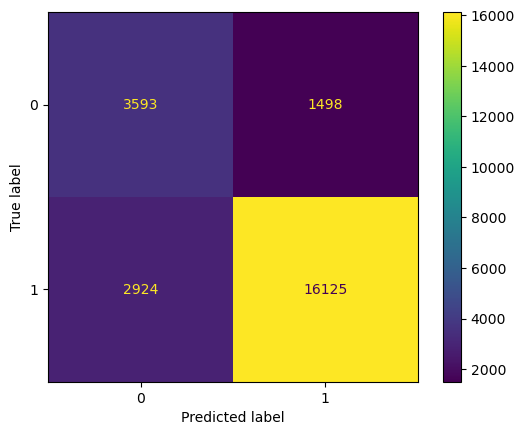

In [283]:
cm = confusion_matrix(y_test, predictions_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### Modelo 2

Accuracy: 86.969%
Accuracy: 85.017%
precision: 87.991%
recall: 93.816%
auc: 88.581%


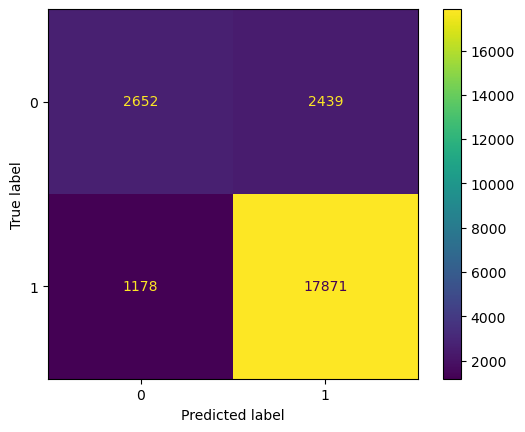

In [312]:
model2 = XGBClassifier()
model2.fit(X2_train, y2_train)

# make predictions for test data
y_pred_test = model2.predict(X2_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = model2.predict(X2_train)
predictions_train = [round(value) for value in y_pred_train]

# evaluate predictions
accuracy = accuracy_score(y2_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y2_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

precision = precision_score(y2_test, predictions_test)
print("precision: %.3f%%" % (precision * 100.0))

recall = recall_score(y2_test, predictions_test)
print("recall: %.3f%%" % (recall * 100.0))

auc = roc_auc_score(y2_test, model2.predict_proba(X2_test)[:, 1])
print("auc: %.3f%%" % (auc * 100.0))

cm = confusion_matrix(y2_test, predictions_test, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp.plot()
plt.show()

## Explainable Boosting Machine

### Modelo 1

#### Treino

In [287]:
ebm = ExplainableBoostingClassifier()

In [288]:
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

#### Avaliação

In [289]:
# make predictions for test data
y_pred_test = ebm.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = ebm.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

In [290]:
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 84.882%
Accuracy: 83.194%


In [291]:
auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.879


In [292]:
X_train.shape

(217258, 18)

In [293]:
show(ebm.explain_global())

### Modelo 2

In [313]:
ebm2 = ExplainableBoostingClassifier()

ebm2.fit(X2_train, y2_train)

# make predictions for test data
y_pred_test = ebm2.predict(X2_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = ebm2.predict(X2_train)
predictions_train = [round(value) for value in y_pred_train]

# evaluate predictions
accuracy = accuracy_score(y2_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y2_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

auc = roc_auc_score(y2_test, ebm2.predict_proba(X2_test)[:, 1])
print("AUC: {:.3f}".format(auc))

Accuracy: 84.811%
Accuracy: 84.379%
AUC: 0.877


In [315]:
show(ebm2.explain_global())

In [316]:
print(X2_test[2])

[1.         0.         0.         0.05695585 0.74551706 0.123909
 0.31570209 0.90091001 0.72497472 0.25       0.94390159 0.5
 0.05353705 0.5        0.43707707]


## Análise de precisão

### Cálculo de xT

In [323]:
import socceraction.xthreat as xt

In [317]:
spadl.head()

match_id    event_id  period_id  time_seconds  team_id          team_name  \
0   2128286  2253487625          1             0       90            Burnley   
1   2128286  2253487639          1             2       90            Burnley   
2   2128286  2253487685          1             7       90            Burnley   
3   2128286  2253487689          1            11       90            Burnley   
4   2128286  2253488053          1            44        1  Manchester United   

   player_id      player_name  type_id type_name  start_x  start_y   end_x  \
0      60551  Ashley Westwood        1      pass   52.815   34.204  32.025   
1      17761  James Tarkowski        1      pass   31.080   36.312  38.220   
2      68983   Matthew Lowton        1      pass   43.365   12.512  90.300   
3      90517     Robbie Brady       12      shot   90.300   49.708  90.300   
4      51940     David de Gea       22  goalkick    5.040   33.728  44.310   

    end_y  result_id result_name  bodypart_id bodypart_name  
0  34.204          1     success            1          foot  
1  15.844          1     success            1          foot  
2  49.708          1     success            1          foot  
3  49.708          0        fail            1          foot  
4  21.012          1     success            1          foot

In [328]:
path = 'https://karun.in/blog/data/open_xt_12x8_v1.json'
xT_model = xt.load_model(path)

In [330]:
xT_model.xT.shape

(8, 12)

In [333]:
import cv2

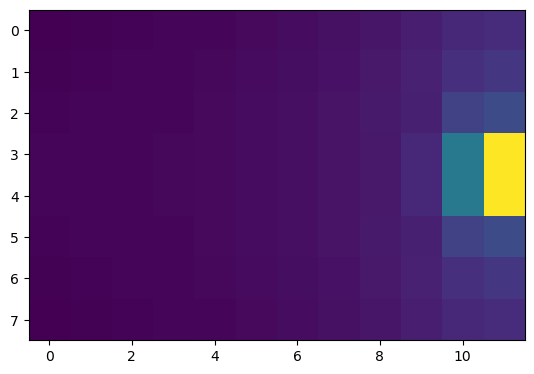

In [334]:
plt.imshow(xT_model.xT)

In [341]:
xT_pitch = cv2.resize(xT_model.xT, (105, 64), interpolation = cv2.INTER_LINEAR )

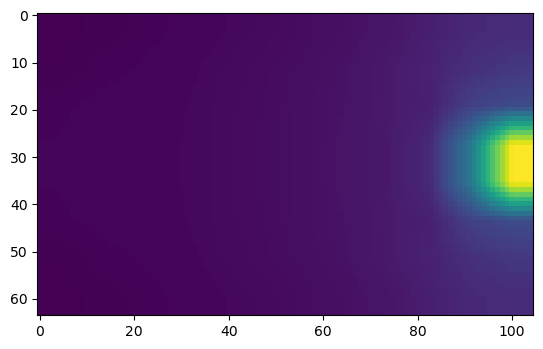

In [342]:
plt.imshow(xT_pitch)

### Cálculo da precisão

#### Passe

In [416]:
pass_event = df_passes.iloc[52]
receiver = int(pass_event['intended_receiver_id'])

In [417]:
receiver

106760

In [418]:
pass_event

match_id                                           2128286
event_id                                        2253490541
period_id                                                1
time_seconds                                           281
team_id                                                  1
team_name                                Manchester United
player_id_x                                          95658
player_name                                  Harry Maguire
type_id                                                  1
type_name                                             pass
start_x                                             54.075
start_y                                              37.74
end_x                                                63.42
end_y                                                63.24
result_id                                                1
result_name                                        success
bodypart_id                                             

In [419]:
pass_tracking = frames_coords[numpy_frames_coords_event_id == pass_event['event_id']]

In [420]:
pass_tracking

match_id    event_id  frame  team team_status        x   x_opta  \
1727   2128286  2253490541   4201     1     offense  52.4785  52.4790   
1728   2128286  2253490541   4201     1     offense  63.0651  63.0630   
1729   2128286  2253490541   4201    90     defense  71.9592  71.9565   
1730   2128286  2253490541   4201     1     offense  43.8894  43.8900   
1731   2128286  2253490541   4201    90     defense  49.6666  49.6650   
1732   2128286  2253490541   4201     1     offense  68.6771  68.6805   
1733   2128286  2253490541   4201    90     defense  70.6336  70.6335   
1734   2128286  2253490541   4201     1     offense  68.8943  68.8905   
1735   2128286  2253490541   4201     1     offense  60.0642  60.0600   
1736   2128286  2253490541   4201    90     defense  69.6080  69.6045   
1737   2128286  2253490541   4201    90     defense  69.9604  69.9615   
1738   2128286  2253490541   4201     1     offense  66.6004  66.6015   
1739   2128286  2253490541   4201     1     offense  47.7822  47.7855   
1740   2128286  2253490541   4201     1     offense  51.9731  51.9750   
1741   2128286  2253490541   4201     1     offense  53.2691  53.2665   
1742   2128286  2253490541   4201    90     defense  53.3944  53.3925   
1743   2128286  2253490541   4201    90     defense  60.9569  60.9525   
1744   2128286  2253490541   4201    90     defense  60.4231  60.4275   
1745   2128286  2253490541   4201    90     defense  58.8440  58.8420   
1746   2128286  2253490541   4201    90     defense  58.8397  58.8420   

       y_opta        y      vx      vy  accel_norm  speed_norm  player_id  \
1727  42.0104  42.0092  1.0990  0.6819      2.6518      1.2933      95658   
1728  66.4224  66.4216 -0.0000 -0.0000      0.0000      0.0000     106760   
1729  55.1480  55.1450  0.5176  2.7555      0.0000      2.8037      68983   
1730  22.6372  22.6381 -0.0000 -0.0000      0.0000      0.0000     197365   
1731  28.0840  28.0816  1.0016 -0.2296      0.1115      1.0276      44699   
1732   5.6916   5.6895  0.5960  1.5350      0.0237      1.6467     176297   
1733  38.2160  38.2150  1.7792  0.5981     -0.8176      1.8771      17761   
1734  34.8024  34.8038 -0.1332  0.8712     -0.8781      0.8813      40720   
1735  49.6944  49.6925  0.2483 -0.6596     -1.9445      0.7047     148225   
1736  29.8656  29.8683  1.1697  0.1382     -0.6677      1.1778      51927   
1737  17.4488  17.4466  1.3055  1.9610     -0.2665      2.3558      39487   
1738  25.9692  25.9673  1.3901  0.7378     -0.5068      1.5738     141746   
1739  57.7660  57.7674  1.5474 -0.3230      0.0000      1.5808      62398   
1740  12.2944  12.2976  1.5246  0.5207     -0.5273      1.6111     214590   
1741  34.3400  34.3377  1.3598  0.8140     -0.3464      1.5848      74208   
1742  45.3152  45.3160  2.1786 -1.7911      1.6699      2.8203      60689   
1743  51.0816  51.0796  0.8496 -0.9909     -0.1113      1.3052      60586   
1744  21.4676  21.4646  1.4017  0.7794     -0.2004      1.6038      90517   
1745  36.3800  36.3789  2.3977  1.4575      0.0844      2.8059     172782   
1746  44.4448  44.4428  0.3217  0.4962     -1.6906      0.5914      60551   

     player_position  player_with_event  
1727             LCB               True  
1728             LWB              False  
1729             RWB              False  
1730             RCB              False  
1731              CF              False  
1732              RW              False  
1733             RCB              False  
1734              CF              False  
1735              LW              False  
1736             LCB              False  
1737             LWB              False  
1738              AM              False  
1739              LM              False  
1740             RWB              False  
1741              RM              False  
1742              RF              False  
1743              RW              False  
1744              LW              False  
1745              LM              False  
1746          

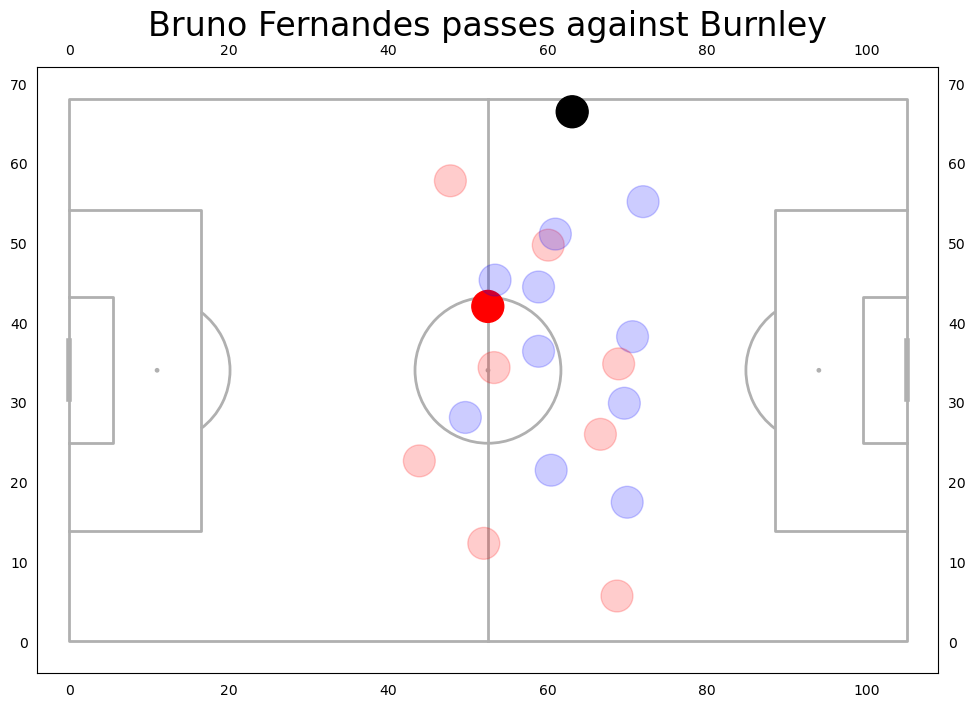

In [421]:
pitch = Pitch(pitch_type='uefa',  # example plotting a tracab pitch
              pitch_length=105, pitch_width=68,
              axis=True, label=True)
fig, ax = pitch.draw(figsize=(10, 7))

for i,row in pass_tracking.iterrows():
        x=row['x_opta']
        y=row['y_opta']
        #plot circle
        if row['player_with_event'] == True:
            passCircle=plt.Circle((x,y),2,color="red")
            passCircle.set_alpha(1)
            ax.add_patch(passCircle)
        elif row['player_id'] == receiver:
            passCircle=plt.Circle((x,y),2,color="black")
            passCircle.set_alpha(1)
            ax.add_patch(passCircle)
        elif row['team_status'] == 'offense':
            passCircle=plt.Circle((x,y),2,color="red")
            passCircle.set_alpha(.2)
            ax.add_patch(passCircle)
        else:
            passCircle=plt.Circle((x,y),2,color="blue")
            passCircle.set_alpha(.2)
            ax.add_patch(passCircle)

        #plot arrow
'''        passArrow=plt.Arrow(x,y,dx,dy,width=3,color="blue")
        ax.add_patch(passArrow)'''

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

#### Receiver's zone of influence

In [432]:
receiver_pos = (pass_tracking[pass_tracking['player_id'] == receiver]['x_opta'].values[0], pass_tracking[pass_tracking['player_id'] == receiver]['y_opta'].values[0])
receiver_dir = (pass_tracking[pass_tracking['player_id'] == receiver]['vx'].values[0], pass_tracking[pass_tracking['player_id'] == receiver]['vy'].values[0])

In [433]:
receiver_speed = np.sqrt(receiver_dir[0] ** 2 + receiver_dir[1] ** 2)

In [436]:
receiver_tta = np.zeros((68, 105))

In [439]:
for x in range(receiver_tta.shape[0]):
    for y in range(receiver_tta.shape[1]):
        dir = ((x - receiver_pos[0]) , (y - receiver_pos[1]))
        dist = np.sqrt((dir[0]) ** 2 + (dir[1])**2)
        receiver_tta[x,y] = time_to_arrive(dist, dir, receiver_dir, receiver_speed)
        if  receiver_tta[x,y] == -1:
            print("-1")


In [442]:
np.max(receiver_tta)

10.327834740257872

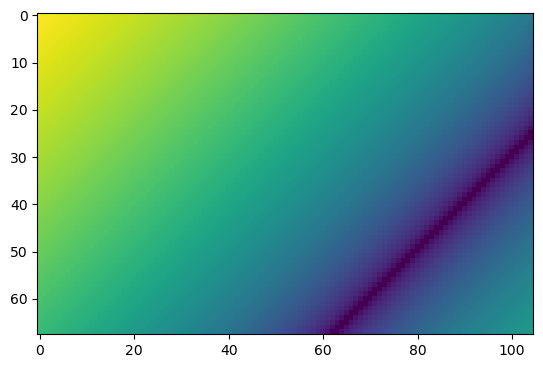

In [440]:
plt.imshow(receiver_tta)